In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 



In [3]:
#nltk.download('punkt')

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [106]:
# Read in data
df = pd.read_csv('../../datasets/amazon-fine-food-reviews/Reviews.csv')
#df = pd.read_csv('/content/drive/MyDrive/datasets/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)


(568454, 10)


In [107]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Distribution of Scores

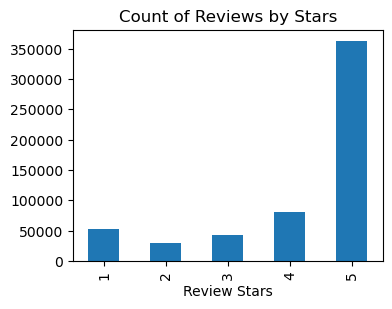

In [108]:
plt.figure(figsize=(4,3))

ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars')
ax.set_xlabel('Review Stars')
plt.show()

Look at an example text

In [5]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


Distribution of text length

In [6]:
lengths = [len(text) for text in df.Text]

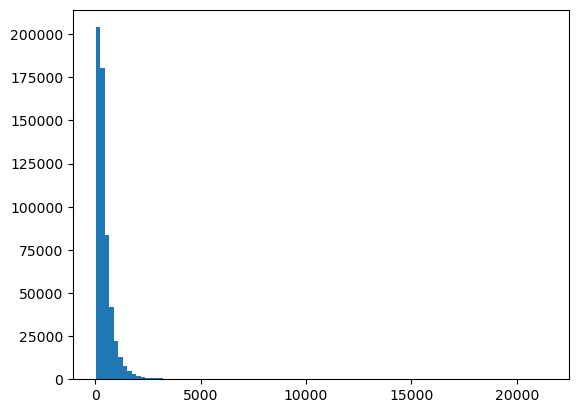

In [7]:
plt.hist(lengths, bins=100);

In [8]:
lengths = [item for item in lengths if item < 3000]

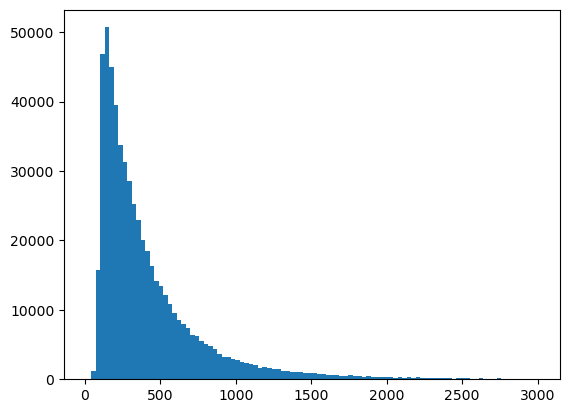

In [9]:
plt.hist(lengths, bins=100);

In [10]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

### Sentiment Analysis with NLTK Vader

NLTK Vader is a simple rule based sentiment analysis model. More information can be found at:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [109]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tevfikaytekin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [110]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [111]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [14]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [15]:
sia.polarity_scores('This is not a good movie.')

{'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'compound': -0.3412}

In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [126]:
from collections import Counter
#df_small = df.sample(n=10000)
df_small = df[:10000].copy()
df_small['Score'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
Counter(df_small.Score)

Counter({1: 7616, 0: 2384})

In [113]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df_small.iterrows(), total=len(df_small)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [114]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_small, how='left')

In [115]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,226905,0.000,0.682,0.318,0.9589,B000AYFCEU,A198JRUIP09HX5,"V. Gera ""deal hound""",0,0,1,1239926400,Yummy Cookies. Taste just like OR*EOs,Great stuff. Didn't expect them to taste as go...
1,122663,0.009,0.842,0.149,0.9449,B00416MT4Y,A1SPZYCSGCMM4E,"''NATUREGIRL'' ""'CALLY""",1,1,1,1329696000,The only healthy cinnamon to have.,Recieved quickly. The one pound bag is huge......
2,125120,0.094,0.748,0.158,0.7904,B000NY8OLK,AAAD48NLZGK2Z,G. Brooks,6,6,0,1289779200,The new recipe is bland plastic-y junk chocolate,I enjoyed Lindt Excellence 70% as a lunch trea...
3,81237,0.000,0.824,0.176,0.8481,B001G7Q1PY,A1ZSPSXWY7LMQQ,"AM ""AM""",2,2,1,1306195200,Dilmah Tea,I think this tea has a lovely light taste to i...
4,25666,0.000,0.825,0.175,0.7316,B0015R9BQG,A2AF1JZ62BOBHV,"Lori L. ""MomsNightOff""",0,0,1,1189468800,Delicious and chewey,This really satisfied my yen for a tasty prote...


In [116]:
print(np.max(vaders.compound))
print(np.min(vaders.compound))

0.9993
-0.9809


In [117]:
print(np.max(vaders.Score))
print(np.min(vaders.Score))

1
0


In [118]:
def scale_score(x):
    return (x+1)/2

scaled_scores = [scale_score(x) for x in vaders.compound]
print(scaled_scores)


[0.9794499999999999, 0.97245, 0.8952, 0.92405, 0.8658, 0.9647, 0.87, 0.79295, 0.9962500000000001, 0.99855, 0.9788, 0.8295, 0.98525, 0.6863, 0.73135, 0.39885, 0.7202, 0.9670000000000001, 0.9752000000000001, 0.93445, 0.9575, 0.7748999999999999, 0.9646, 0.96565, 0.569, 0.32999999999999996, 0.9634499999999999, 0.9875, 0.91355, 0.6909, 0.6909, 0.7754, 0.9783999999999999, 0.7377, 0.88585, 0.8694999999999999, 0.99015, 0.96785, 0.5, 0.9749, 0.6888, 0.9699, 0.9769, 0.96955, 0.20639999999999997, 0.933, 0.9898, 0.352, 0.8842, 0.98115, 0.9792000000000001, 0.3476, 0.74695, 0.7406, 0.81845, 0.7787, 0.66455, 0.25015, 0.99535, 0.95945, 0.9903500000000001, 0.9875499999999999, 0.9639, 0.90505, 0.6909, 0.9553, 0.9783999999999999, 0.85015, 0.9158, 0.95915, 0.9698, 0.8271, 0.93325, 0.9685, 0.9358500000000001, 0.6706, 0.9691000000000001, 0.92535, 0.9620500000000001, 0.97395, 0.9220999999999999, 0.39015, 0.9858, 0.9179999999999999, 0.9521, 0.58895, 0.352, 0.97285, 0.61805, 0.9061, 0.352, 0.41195, 0.9519, 0.1

In [119]:
print("MAE:", mean_absolute_error(vaders.Score, scaled_scores))
print("MSE:", mean_squared_error(vaders.Score, scaled_scores))

MAE: 0.23100699
MSE: 0.14032854740050002


For comparison, following shows the performance of random guess

In [120]:
random_scores = np.random.uniform(0, 1, len(vaders))
print("MAE random:", mean_absolute_error(vaders.Score,random_scores))
print("MSE random:", mean_squared_error(vaders.Score, random_scores))

random_scores = np.random.randint(0, 2, len(vaders))
print(classification_report(vaders.Score,random_scores))
print(confusion_matrix(vaders.Score,random_scores))



MAE random: 0.500141117090162
MSE random: 0.3339607224044838
              precision    recall  f1-score   support

           0       0.22      0.52      0.31      2158
           1       0.79      0.50      0.61      7842

    accuracy                           0.50     10000
   macro avg       0.50      0.51      0.46     10000
weighted avg       0.67      0.50      0.54     10000

[[1113 1045]
 [3948 3894]]


In [121]:
Counter(vaders.Score)

Counter({1: 7842, 0: 2158})

### Sentiment Analysis with machine learning

In [127]:
#df_small = df.sample(n=10000)
df_small = df[:10000].copy()
df_small['Score'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
Counter(df_small.Score)

Counter({1: 7616, 0: 2384})

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X = tfidf_vectorizer.fit_transform(df_small['Text'])
y = df_small['Score'].values

In [61]:
X.shape

(10000, 10000)

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model1 = LGBMClassifier()
model2 = LGBMRegressor()
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# Predict and evaluate the classifier
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)

print("MAE classifier:", mean_absolute_error(y_test, predictions1))
print("MSE classifier:", mean_squared_error(y_test, predictions1))

print(classification_report(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))

print("MAE regressor:", mean_absolute_error(y_test, predictions2))
print("MSE regressor:", mean_squared_error(y_test, predictions2))

[LightGBM] [Info] Number of positive: 6871, number of negative: 2129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.298181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100031
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 2260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763444 -> initscore=1.171657
[LightGBM] [Info] Start training from score 1.171657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100031
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 2260
[LightGBM] [Info] Start training from score 0.763444
MAE classifier: 0.136
MSE classifi

In [65]:
Counter(y_test)

Counter({1: 781, -1: 219})

In [ ]:
np.random.randint(-1,2)

Results are better than the rule based sentiment analysis. Note that, we did not use the entire dataset, more data will improve the performance of the ML classifiers. Aslo note that this is a simple TFIDF+ML implementation, there is room for improvement. Another thing to note is that modeling the problem as a classification problem (as opposed to a regression problem) gave better results in terms of MAE but worse results in terms of MSE. This is reasonable since for the classifier predicting a wrong class amounts to the same error regardless of the actaul value, so the classifier optimizes for predicting the correct class rather than predicting a class which is numerically closer. On the other hand the regressor tries to minimize the distance between the actual value and the prediction. Hence we get lower MAE but higher MSE using a classifier.

### Word Embeddings

In [66]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader
from nltk.tokenize import RegexpTokenizer


In [67]:
embeddings = gensim.downloader.load('glove-twitter-25')

In [68]:
import re

def simple_preprocess(text):
    text = text.lower()  # convert text to lower-case
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I|re.A)  # remove non-letters
    text = re.sub(r"\s+", " ", text).strip()  # remove excess whitespace
    return text

In [69]:
def text_to_vector(text, embeddings):
    tokenizer = RegexpTokenizer(r'\w+')

    tokens = simple_preprocess(text)
    
    vectors = []
    
    for token in tokenizer.tokenize(tokens):
        # Check if the token is in the embeddings vocabulary
        if token in embeddings:
            vectors.append(embeddings[token])
    
    # If we found any vectors, calculate the mean, otherwise return a zero vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embeddings.vector_size)  



In [70]:
# Convert texts to vectors
vectorized_texts = df_small['Text'].apply(lambda x: text_to_vector(x, embeddings))

# Convert to numpy array
X = np.array(vectorized_texts.tolist())
y = df_small['Score'].values


In [71]:
print(X.shape)
X

(10000, 25)


array([[-0.32177737,  0.11186924,  0.2944345 , ...,  0.00684596,
        -0.04885194, -0.21955979],
       [-0.17622216,  0.19141142,  0.14154655, ..., -0.0460256 ,
         0.04607968, -0.16541734],
       [-0.11229096,  0.1757816 , -0.03603461, ...,  0.06178362,
        -0.03969003, -0.25814965],
       ...,
       [-0.34509858,  0.06551484,  0.25724173, ...,  0.08161405,
         0.07249137, -0.23463704],
       [-0.31269816,  0.18445353,  0.04932653, ..., -0.1560497 ,
         0.00046292, -0.1122091 ],
       [-0.11224597,  0.21784422,  0.2580789 , ...,  0.07429439,
         0.05488412, -0.10959364]], dtype=float32)

In [72]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model1 = LGBMClassifier()
model2 = LGBMRegressor()
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# Predict and evaluate the classifier
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)

print("MAE classifier:", mean_absolute_error(y_test, predictions1))
print("MSE classifier:", mean_squared_error(y_test, predictions1))

print(classification_report(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))

print("MAE regressor:", mean_absolute_error(y_test, predictions2))
print("MSE regressor:", mean_squared_error(y_test, predictions2))


[LightGBM] [Info] Number of positive: 7037, number of negative: 1963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.781889 -> initscore=1.276708
[LightGBM] [Info] Start training from score 1.276708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 25
[LightGBM] [Info] Start training from score 0.563778
MAE classifier: 0.432
MSE classifier: 0.864
              precision    recall  f1-score   support

       

### Doc2Vec


In [89]:
texts = df_small['Text'].tolist()
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

In [90]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [91]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_texts)]

In [92]:
documents[:5]

[TaggedDocument(words=['i', 'use', 'the', 'torani', 'syrup', 'to', 'flavor', 'my', 'morning', 'oatmeal', '.', 'i', 'had', 'been', 'using', 'carmrl', 'and', 'chocolate', 'flavors', ',', 'but', 'wanted', 'to', 'try', 'a', 'different', 'flavor', '.', 'the', 'brown', 'sugar', 'cinnamon', 'is', 'pretty', 'good', '-', 'but', 'not', 'my', 'favorite', '(', 'i', 'like', 'the', 'chocolate', 'the', 'best', ')', '.', 'i', 'was', 'surprised', 'that', 'these', 'bottles', 'were', 'quite', 'a', 'bit', 'larger', 'than', 'the', '750', 'ml', 'bottles', 'i', 'had', 'been', 'getting', '.', 'hence', 'the', 'reason', 'for', 'the', 'slightly', 'greater', 'price', '.'], tags=[0]),
 TaggedDocument(words=['i', "'m", 'gluten', 'free', 'and', 'on', 'the', 'go', '.', 'grabbing', 'this', 'on', 'my', 'way', 'in', 'or', 'out', 'is', 'a', 'quick', 'and', 'easy', 'way', 'to', 'ease', 'hunger', 'or', 'cravings', '.', 'and', 'it', 'is', 'so', 'good', 'for', 'you', ',', 'too', '!'], tags=[1]),
 TaggedDocument(words=['he', 

In [99]:
model = Doc2Vec(documents, epochs=30)

In [102]:
# Convert texts to vectors
vectorized_texts = df_small['Text'].apply(lambda x: model.infer_vector(word_tokenize(x.lower())))

# Convert to numpy array
X = np.array(vectorized_texts.tolist())
y = df_small['Score'].values

In [103]:
X

array([[-0.52801806,  0.24901031,  0.13722797, ..., -0.13942836,
        -1.3981177 , -0.61421883],
       [-0.48453715,  0.3218715 ,  0.31841215, ..., -0.66468513,
         0.570333  , -0.6065332 ],
       [ 0.28460848, -0.41195086, -0.07580801, ..., -0.6867216 ,
        -0.32974234, -0.2326336 ],
       ...,
       [-0.10609289, -0.15791713, -0.3050419 , ..., -0.46781924,
        -0.05644299, -0.11112674],
       [ 0.57516176, -0.00166643, -0.00891723, ..., -0.23172179,
        -0.3661845 ,  0.5193122 ],
       [ 0.275127  , -0.24533929, -0.01040907, ..., -0.25439987,
        -0.18783328, -0.21604383]], dtype=float32)

In [104]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model1 = LGBMClassifier()
model2 = LGBMRegressor()
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# Predict and evaluate the classifier
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)

print("MAE classifier:", mean_absolute_error(y_test, predictions1))
print("MSE classifier:", mean_squared_error(y_test, predictions1))

print(classification_report(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))

print("MAE regressor:", mean_absolute_error(y_test, predictions2))
print("MSE regressor:", mean_squared_error(y_test, predictions2))

[LightGBM] [Info] Number of positive: 7040, number of negative: 1960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.782222 -> initscore=1.278664
[LightGBM] [Info] Start training from score 1.278664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 100
[LightGBM] [Info] Start training from score 0.782222
MAE classifier: 0.191
MSE classifier: 0.191
              precision    recall  f1-score   support

           0       0.74      0.29      0.41       235
           1 